Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

# Uses our ordered list of words (words) from the original text
def build_dataset(words):

  # Create a list (count) containing the 50K most popular words along with the number of times they occur
  # the first entry in the list shows the number of all other words, the count for these will get populated later
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
  # We want a unique identifier (index in count) for each of our 50K most popular words, for this we use a dict
  # In dictionary, the key is the word and the value is the index
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)

  # Create a list of indices (data) from our list of words (words)
  # The index refers to the position of the word in count
  # Also calcluate the count for of all non-popular words and update the count for these
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count

  # It's useful to have a dict like dictionary but with the keys and values reversed
  # In reverse_dictionary, the key is the index and the value is the word
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

  # words = our original list of words
  # count[i] = [ith most popular word, number of occurences in words]
  # data[i] = index_in_count of the ith word in words, has same length as words
  # dictionary = dict( key:value = word:index_in_count ) 
  # reverse_dictionary = dict( key:value = index_in_count:word )
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'anarchism', 'a', 'of', 'term', 'originated', 'as']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.=
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable( tf.truncated_normal( [vocabulary_size, embedding_size],
                                                      stddev=1.0/math.sqrt(embedding_size) ) )
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                   train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [9]:
num_steps = 100001
steps_jump = 2000
steps_array = np.arange(0, num_steps, steps_jump)
import pandas as pd
results_df = pd.DataFrame(
    index = steps_array,
    columns = ['skip-gram', 'cbow'])

In [10]:
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      results_df['skip-gram'][step] = average_loss
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

results_df[['skip-gram']]

Initialized
Average loss at step 0: 7.934552
Nearest to b: landholdings, bout, daytime, informatique, identify, fabricate, visiting, riddler,
Nearest to this: phillies, turtledove, semicircular, stricken, rearranged, hulk, shook, hellfire,
Nearest to from: plotting, pacified, change, fades, dearly, eleftherios, alfonso, poland,
Nearest to these: whit, joined, widehat, hermitian, cores, penchant, pared, heavy,
Nearest to is: trismegistus, tormented, shorthair, arrows, admitting, macau, bassoonist, bombers,
Nearest to american: leader, intergovernmental, shootout, azrael, bacteria, afar, reins, also,
Nearest to are: interactivity, maxillofacial, hussites, adjoining, discriminant, concerned, outposts, activated,
Nearest to no: cfo, demonstrating, totally, rv, kasner, chomsky, discoveries, aden,
Nearest to four: landless, prokaryotes, burgnich, contemptuous, propagandist, garlic, erstwhile, gren,
Nearest to would: konkan, expensive, christie, pepin, bhfiann, senado, lansing, scsi,
Nearest 

,skip-gram
0,7.93455
2000,4.35645
4000,3.85938
6000,3.7924
8000,3.68635
10000,3.61395
12000,3.6051
14000,3.57661
16000,3.41188
18000,3.45604


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


[<matplotlib.text.Text at 0x11c942d10>, <matplotlib.text.Text at 0x102135110>]

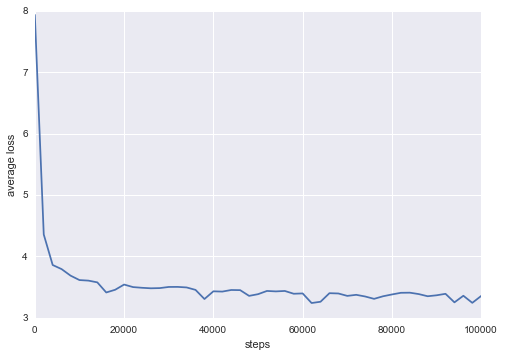

In [11]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

ax = results_df['skip-gram'].plot()
ax.set(xlabel="steps", ylabel="average loss")

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

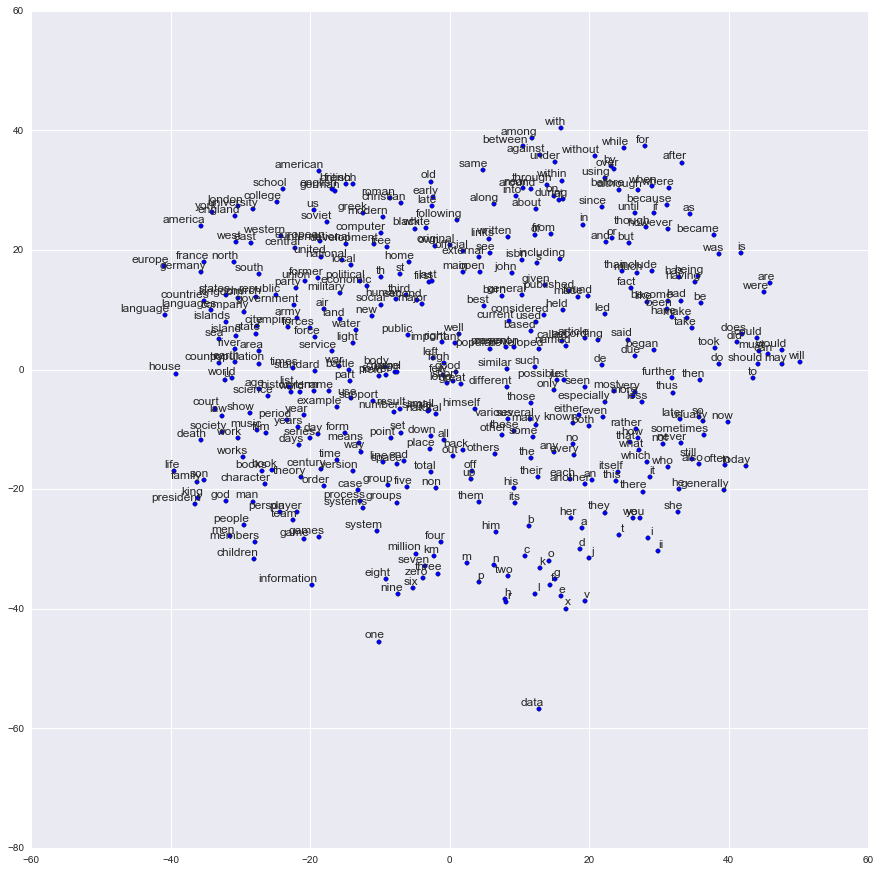

In [13]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [14]:
data_index = 0

def generate_batch_cbow(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)    
  for i in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    for j in range(skip_window):
      batch[i, j            ] = buffer[j              ]
      batch[i, j+skip_window] = buffer[j+skip_window+1]
    labels[i, 0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    display('batch:')
    display([[reverse_dictionary[i] for i in bi] for bi in batch])
    display('labels:')
    display([reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:


'batch:'

[['anarchism', 'as'],
 ['originated', 'a'],
 ['as', 'term'],
 ['a', 'of'],
 ['term', 'abuse'],
 ['of', 'first'],
 ['abuse', 'used'],
 ['first', 'against']]

'labels:'

['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


with num_skips = 4 and skip_window = 2:


'batch:'

[['anarchism', 'originated', 'a', 'term'],
 ['originated', 'as', 'term', 'of'],
 ['as', 'a', 'of', 'abuse'],
 ['a', 'term', 'abuse', 'first'],
 ['term', 'of', 'first', 'used'],
 ['of', 'abuse', 'used', 'against'],
 ['abuse', 'first', 'against', 'early'],
 ['first', 'used', 'early', 'working']]

'labels:'

['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

In [15]:
import random

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable( tf.truncated_normal( [vocabulary_size, embedding_size],
                                                      stddev=1.0/math.sqrt(embedding_size) ) )
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  #embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  embed = tf.zeros([batch_size, embedding_size])
  for j in range(num_skips):
    embed += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])

  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                   train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [16]:
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      results_df['cbow'][step] = average_loss
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

results_df

Initialized
Average loss at step 0: 7.831627
Nearest to about: miki, asser, fridtjof, hanns, stereo, loaders, per, nanometers,
Nearest to war: purer, openoffice, carps, persuades, francis, prejudice, puma, cancellation,
Nearest to years: fasting, monism, determinative, indictment, creditor, caspian, ssn, drops,
Nearest to were: dahalo, content, philosophicus, succinct, congenial, wearing, nephites, vented,
Nearest to used: phobia, boaz, cannot, fauna, borgir, reuel, nostratic, aeneas,
Nearest to zero: beanstalk, reliability, arion, igm, sz, lights, carangi, monopolize,
Nearest to this: expositor, soaps, gastroenterology, heinemann, madness, emphases, figaro, vizier,
Nearest to a: capitalist, discoveries, margaret, expelled, medicines, wavetable, anic, andersonville,
Nearest to are: kes, reconstruct, meiji, requests, redefined, painting, kilo, carpenter,
Nearest to five: arts, whispers, spirituality, swerve, blacklist, confrontational, blish, spaces,
Nearest to to: sounding, pulsation, 

,skip-gram,cbow
0,7.93455,7.83163
2000,4.35645,4.09836
4000,3.85938,3.56248
6000,3.7924,3.39023
8000,3.68635,3.24265
10000,3.61395,3.17348
12000,3.6051,3.20449
14000,3.57661,3.15077
16000,3.41188,3.18075
18000,3.45604,3.13135


[<matplotlib.text.Text at 0x113e0be10>, <matplotlib.text.Text at 0x113e0b290>]

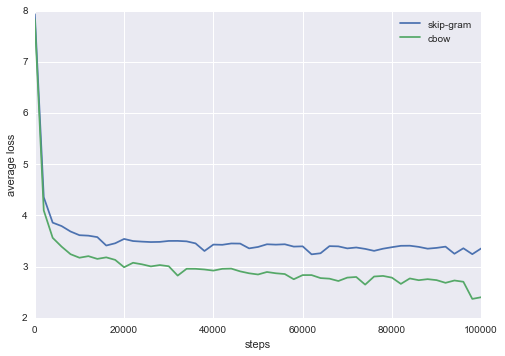

In [17]:
ax = results_df.plot()
ax.set(xlabel="steps", ylabel="average loss")

In [18]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

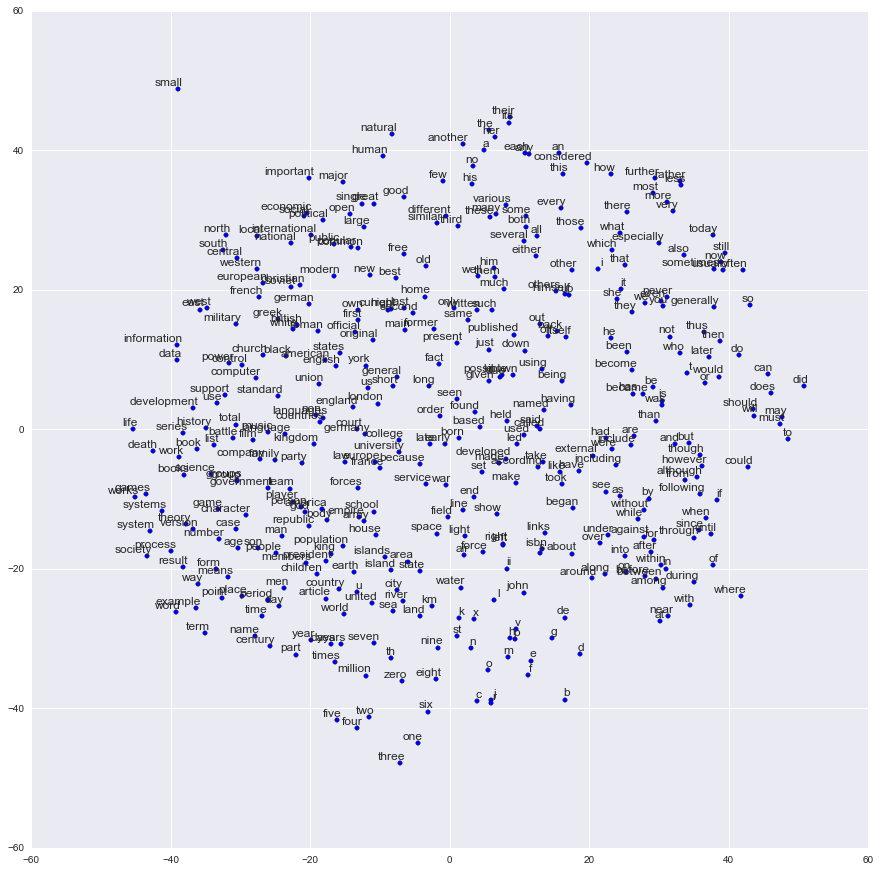

In [19]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)